In [59]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import pandas as pd
import seaborn as sns
import numpy as np
import arviz as az
import scipy as sp
import seaborn as sns
import warnings
#from statsmodels import datasets
#from theano import shared, tensor as tt
#import janitor

%matplotlib inline
warnings.simplefilter(action="ignore", category=FutureWarning)

In [60]:
import pymc3 as pm

In [61]:
#%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("default")

In [62]:
#sns.set_style('whitegrid')
#Colors codes
# c ='#EEA47FFF'  orange
# c ='#00539CFF' blue
# color='#ff00a9'  pink

#Functions definitions

def plot_traces(traces, retain=0):
    '''
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = az.plot_trace(traces[-retain:],
                      lines=tuple([(k, {}, v['mean'])
                                   for k, v in pm.summary(traces[-retain:]).iterrows()]))
    
    for i, mn in enumerate(pm.summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='red')
        
    
    
SEED = 845199 # from random.org, for reproducibility

SAMPLE_KWARGS = {
    'chains': 2,
    
    'random_seed': [
        SEED,
        SEED + 1,
    
    ]
}

#'tune': 1000,

In [64]:
#Import the dataframe

df = (pd.read_csv('./fatData1102.csv'))

In [65]:
#Data scaling

dfs = [x for _, x in df.groupby('steel')]
data_array = np.array([dfs[0].logCycles.values, dfs[1].logCycles.values])
data_array.shape

(2, 32)

In [66]:
from sklearn import preprocessing

In [67]:
robust_scaler = preprocessing.RobustScaler()
logCycles_scaled = robust_scaler.fit_transform(np.transpose(data_array))

In [68]:
data_logCycles_scaled =pd.DataFrame(logCycles_scaled, columns=['304', '316'])
df['logCycles_scaled'] =logCycles_scaled.ravel(order='F')

In [83]:
df.to_csv('./fatdata1103.csv')

<AxesSubplot:ylabel='Count'>

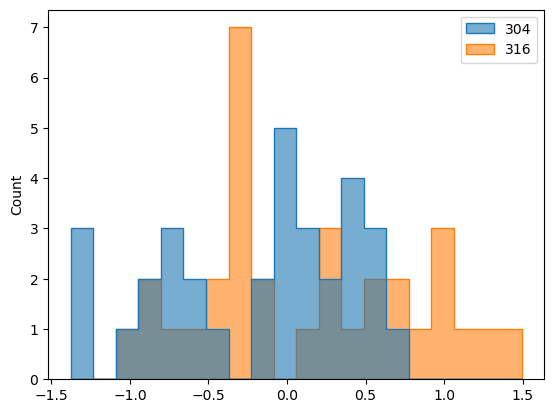

In [70]:
#Scaled data histogram

data_hist =plt.figure()
data_hist.add_axes(sns.histplot(data=data_logCycles_scaled, element="step",bins=20, alpha=0.6))
#data_hist.savefig('./figs/data_hist.png', dpi=300)

In [71]:
data_logCycles_scaled.describe()

,304,316
count,3.200000e+01,32.000000
mean,-1.958999e-01,0.139000
std,5.973288e-01,0.692641
min,-1.377175e+00,-1.081460
25%,-6.788785e-01,-0.328659
50%,1.521136e-16,0.000000
75%,3.211215e-01,0.671341
max,7.527237e-01,1.493681


In [72]:
#Creation of the dataframe for the bauessian regression

data= df[['D','A','ACD', 'AD','AC','BCD', 'BD','logCycles','logCycles_scaled','steel']]


# Basic regression model

In [73]:
import statsmodels.api as sm
x_param = data[['D', 'A','AD', 'AC','BD','ACD', 'BCD']]
y_pred = data['logCycles_scaled']
# with statsmodels
X = sm.add_constant(x_param) # adding a constant
 
res = sm.OLS(y_pred, X).fit()
predictions = res.predict(X) 
 
print_model = res.summary(alpha = 0.1)
print(print_model)
resid=res.outlier_test()
#print(resid)
#print('Parameters: ', res.params)
#print('Standard errors: ', res.bse)
#print('Predicted values: ', res.predict())

                            OLS Regression Results                            
Dep. Variable:       logCycles_scaled   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     1.808
Date:                Sat, 15 May 2021   Prob (F-statistic):              0.104
Time:                        11:51:08   Log-Likelihood:                -57.526
No. Observations:                  64   AIC:                             131.1
Df Residuals:                      56   BIC:                             148.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|       [0.05       0.95]
------------------------------------------------------------------------------
const         -0.0284      0.079     -0.358      0.7

# Bayesian robast regression model 

In [74]:
with pm.Model() as robast_regr_model:
    
    #Define weakly informative priors
    #priors={'Intercept': pm.Normal.dist(mu=0, sd=1),
       #   'Regressor': pm.Normal.dist(mu=0,sd=1)
        #}
    #Define priors for Sikelihood Student T distribution
   # nu = pm.Gamma('nu', alpha=2, beta=0.1)+1
    
    
    
    pm.glm.GLM.from_formula('logCycles ~ D + A + AD + AC + BD + ACD +BCD', 
                            data, family=pm.glm.families.StudentT())  
    
    trace = pm.sample(5000, 
                     **SAMPLE_KWARGS)               

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lam, BCD, ACD, BD, AC, AD, A, D, Intercept]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 436 seconds.


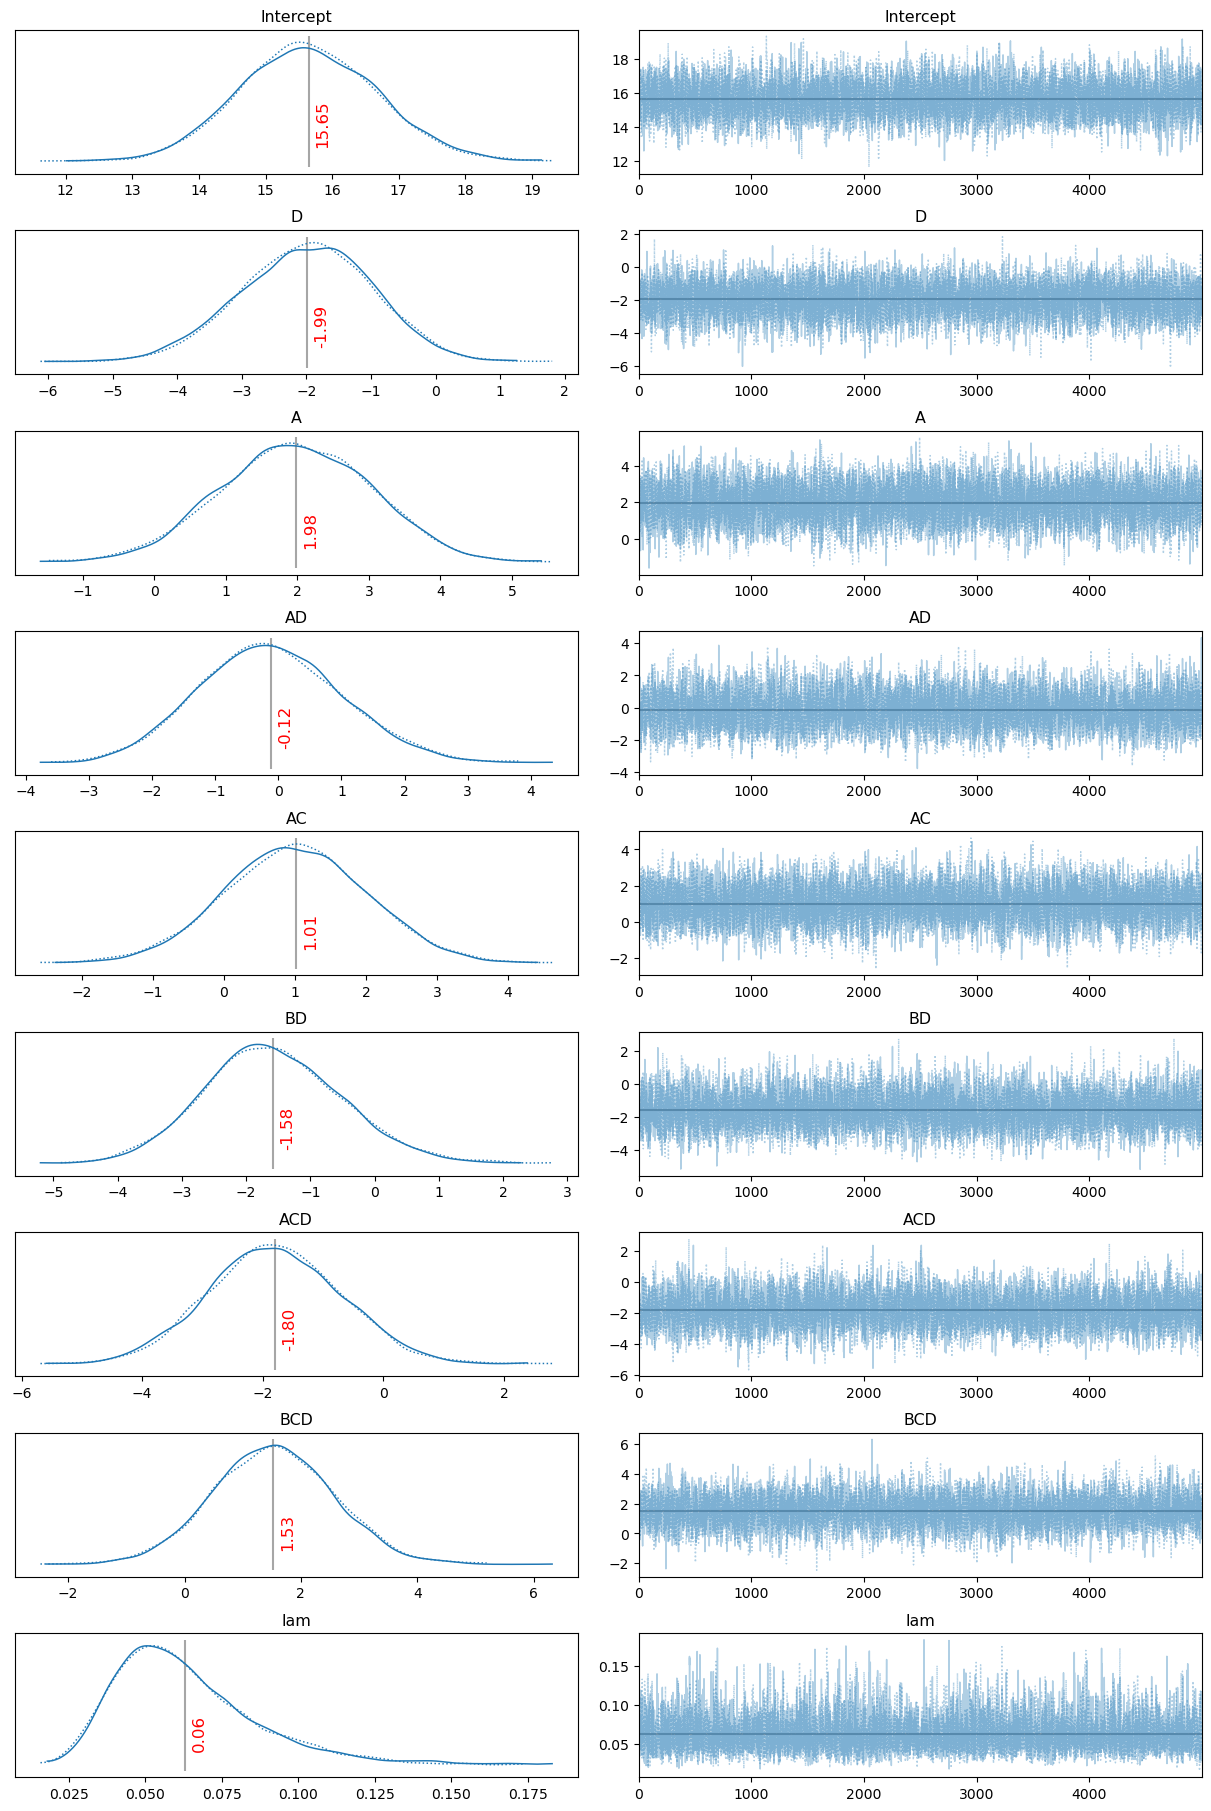

In [76]:
plot_traces(trace);

In [77]:
pm.summary(trace, hdi_prob=0.90)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,15.646,1.025,14.028,17.391,0.012,0.008,7871.0,6804.0,1.0
D,-1.994,1.014,-3.657,-0.330,0.012,0.009,7691.0,7655.0,1.0
A,1.977,1.045,0.320,3.726,0.013,0.009,6825.0,6941.0,1.0
AD,-0.121,1.118,-1.942,1.720,0.015,0.011,5359.0,6500.0,1.0
AC,1.013,1.000,-0.573,2.716,0.011,0.008,7932.0,7860.0,1.0
BD,-1.585,1.068,-3.350,0.162,0.013,0.009,6750.0,6602.0,1.0
ACD,-1.800,1.095,-3.516,0.065,0.014,0.010,6151.0,6966.0,1.0
BCD,1.526,1.040,-0.092,3.301,0.013,0.010,6564.0,6074.0,1.0
lam,0.063,0.023,0.029,0.098,0.000,0.000,7211.0,4976.0,1.0


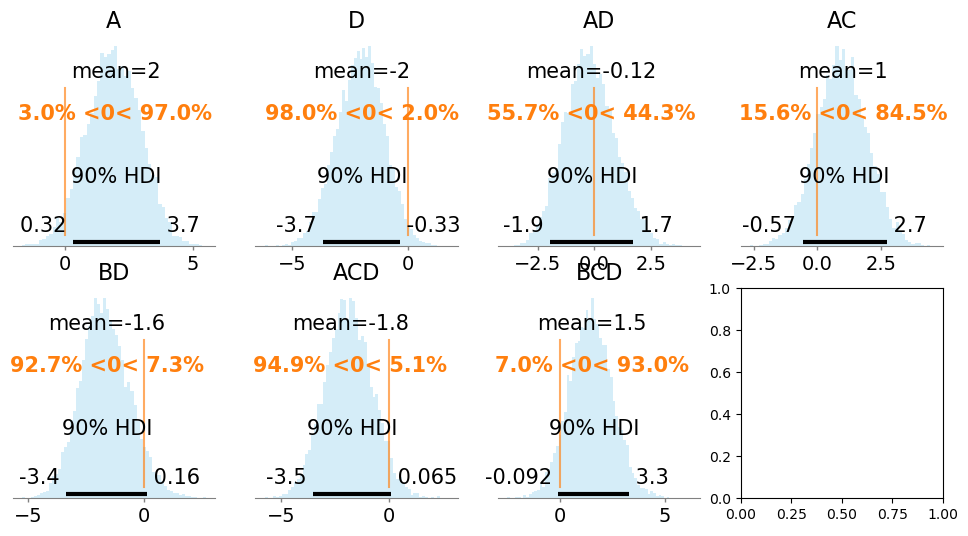

In [79]:
figar, ax =plt.subplots(nrows=2,ncols=4, figsize=(12,6))
az.plot_posterior(trace, kind ='hist',
                  var_names = ['A','D', 'AD', 'AC','BD', 'ACD', 'BCD'],
                    ref_val=0,hdi_prob=0.90,
                  color='#89ceeb', ax=ax);

In [152]:
#figar.savefig('./figs/posterior_hist_weak_priors_scaled.png', dpi=300)

## Posterior predictive check

In [80]:
ppc = pm.sample_posterior_predictive(trace, var_names = ['y'],
                                     model=robast_regr_model, samples=1000,
                                        progressbar= False)
new_data = ppc['y']

new_data.min(axis=1).shape

C:\Users\DiyanDimitrov\anaconda3\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


(1000,)

posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


(-10.0, 40.0)

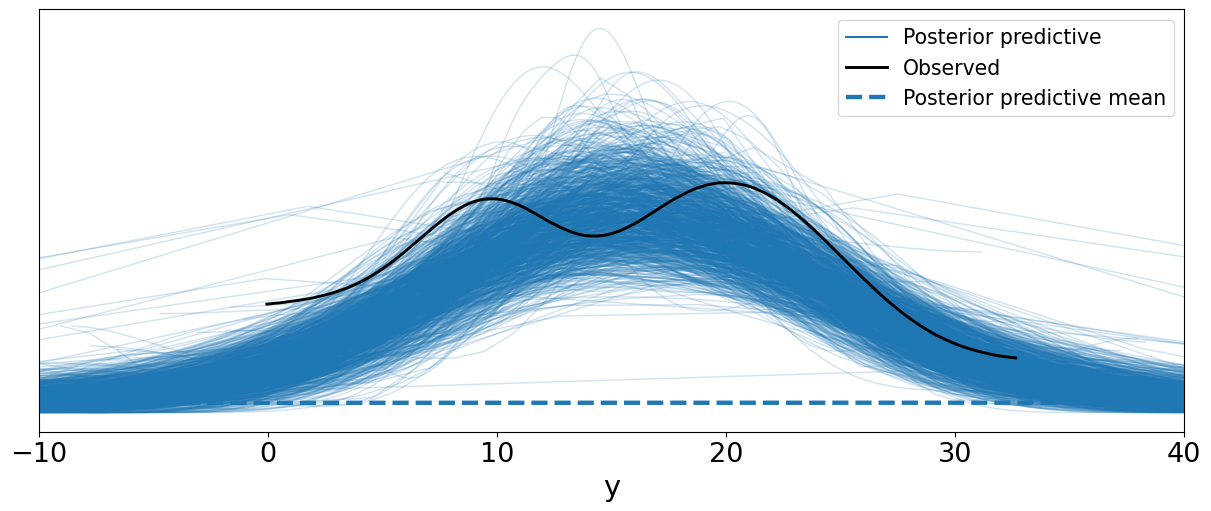

In [86]:
idata = az.from_pymc3(trace=trace, posterior_predictive=ppc)
az.plot_ppc(idata, figsize=(12, 5));
plt.xlim([-10,40])

In [ ]:
import pickle

In [ ]:
with open('robast_regr_model_pickle','wb') as f:
    pickle.dump(robast_regr_model, f)

In [11]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
numpy   1.19.2
seaborn 0.11.1
pandas  1.2.3
scipy   1.6.2
arviz   0.11.0
last updated: Sat Apr 03 2021 

CPython 3.7.9
IPython 7.22.0
watermark 2.0.2
